In [1]:
from AMAT.planet import Planet
from AMAT.vehicle import Vehicle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime
import msise00

from scipy.interpolate import interp1d

import iri2016.altitude as iri

import igrf12


# Set up the planet and atmosphere model.
planet=Planet("EARTH")
planet.loadAtmosphereModel('../../../../AMAT/AMAT/atmdata/Earth/earth-gram-avg.dat', 0 , 1 ,2, 3)

planet.h_skip = 3000.0E3
planet.h_thres= 3000.0E3
planet.h_trap =  80.0E3

# Set up the vehicle
vehicle=Vehicle('MAG-01', 5.0, 83.0, 0.0, 0.03, 0.0, 0.01, planet)

# Set up entry parameters
vehicle.setInitialState(500.0,0.0,0.0,7.116887201350244,0.0,0.00,0.0,0.0)

# Set up solver
vehicle.setSolverParams(1E-6)

glat = 0.0
glon = 0.0
alt_km = np.arange(0.0, 2110, 20.0)
time = datetime(2013, 12, 13, 13, 0, 0)

atmos = msise00.run(time, alt_km, glat, glon)


ATM_height = atmos.alt_km
ATM_density= atmos.Total[0,:,0,0]

planet.density_int   = interp1d(ATM_height*1E3, ATM_density, kind='linear', fill_value=0.0, bounds_error=False)

sim=iri.main(time, (200.0, 2110, 20.0), 0, 0)

alt_arr    = sim['alt_km']
nO_arr     = sim['nO+']
nH_arr     = sim['nH+']

mass_density = (sim['nO+']*16+sim['nH+']*1.0)*1.67E-27

mass_density_int = interp1d(alt_arr*1E3, mass_density, kind='linear', fill_value=0.0, bounds_error=False)

mag = igrf12.igrf('2010-07-12', glat=0, glon=0, alt_km=np.linspace(200,2110,20))

B0_int = interp1d(mag['alt_km']*1E3, mag['total']*1E-9, kind='linear', fill_value=0.0, bounds_error=False)


In [2]:
def compute_drag(rho, v, CD, S):
    return 0.5*rho*v**2*S*CD

In [3]:
def compute_rho(altitude_km):
    return float(planet.density_int(altitude_km*1E3))

In [4]:
def compute_v(altitude_km):
    return np.sqrt(planet.GM/(planet.RP+altitude_km*1E3))

In [5]:
def compute_aero_drag(altitude_km, CD, S):
    rho = compute_rho(altitude_km)
    v   = compute_v(altitude_km)
    
    D   = compute_drag(rho, v, CD, S)
    
    return D

In [6]:
def compute_L(Md, rho, v):
    
    return np.power(4*np.pi*1E-7*Md**2/(4*np.pi**2*rho*v**2), 1.0/6.0)

In [7]:
def compute_mass_dens(altitude_km):
    return float(mass_density_int(altitude_km*1E3))

In [8]:
compute_mass_dens(500.0)

2.395091175391232e-14

In [9]:
compute_L(10, 2.29469813211136e-14, 7600.0)

1.157220797349967

In [10]:
def compute_mhd_drag(altitude_km, Md, CD):
    rho = compute_mass_dens(altitude_km)
    v   = compute_v(altitude_km)
    
    L   = compute_L(Md, rho, v)
    S   = np.pi*L**2
    
    D   = compute_drag(rho, v, CD, S)
    
    return D

In [11]:
def compute_mhd_dragp(altitude_km, Md, CD):
    rho = compute_mass_dens(altitude_km)
    v   = compute_v(altitude_km)
    
    L   = compute_L(Md, rho, v)/2.0
    S   = np.pi*L**2
    
    D   = compute_drag(rho, v, CD, S)
    
    return D

In [12]:
def compute_B0(altitude_km):
    return float(B0_int(altitude_km*1E3))

In [13]:
def compute_Alfven_speed(altitude_km):
    
    B0 = compute_B0(altitude_km)
    rho = compute_mass_dens(altitude_km)
    
    mu_0 = 4*np.pi*1E-7
     
    return B0/np.sqrt(mu_0*rho)

In [14]:
def compute_Alfven_drag(R, alpha, B_eq, altitude_km, theta, theta_M):
    
    rho= compute_mass_dens(altitude_km)
    vA = compute_Alfven_speed(altitude_km)
    v0 = compute_v(altitude_km)
    B0 = compute_B0(altitude_km)
    
    mu_0 = 4*np.pi*1E-7
 
    MA = v0/vA
     
    if B_eq!=0:
        R_eff = R*(B_eq/B0)**(1.0/3.0)*np.sqrt(3.0*np.cos(theta_M/2.0))
    else:
        R_eff = R
    
    P =  2*np.pi*(R_eff**2)*(alpha*MA*B0*np.cos(theta))**2*(vA/mu_0)
    
    D = P / v0
    
    return D

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


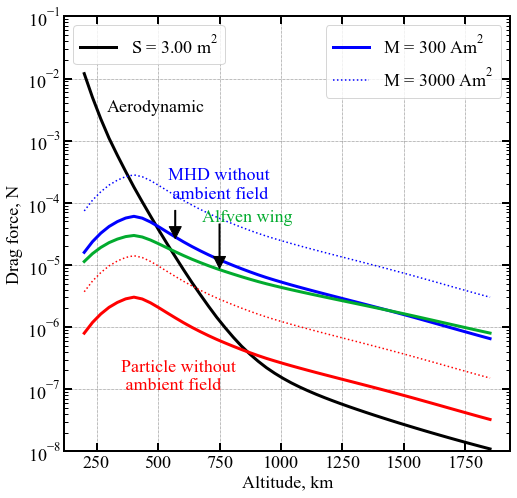

In [22]:
alt_array = np.linspace(200.0,1850.0,50)

aero_drag_01 = np.zeros(len(alt_array))
aero_drag_03 = np.zeros(len(alt_array))

mhd_drag_10  = np.zeros(len(alt_array))
mhd_drag_30  = np.zeros(len(alt_array))
mhd_drag_300  = np.zeros(len(alt_array))

mhd_drag_300p  = np.zeros(len(alt_array))


mhd_drag_10p  = np.zeros(len(alt_array))
mhd_drag_30p  = np.zeros(len(alt_array))


alf_drag_10  = np.zeros(len(alt_array))
alf_drag_30  = np.zeros(len(alt_array))


for i in range(0, len(alt_array)):
    aero_drag_01[i] = compute_aero_drag(alt_array[i], 0.5, 0.01)
    aero_drag_03[i] = compute_aero_drag(alt_array[i], 0.5, 3.00)
    
    mhd_drag_10[i]  = compute_mhd_drag(alt_array[i], 10, 1.5)
    mhd_drag_30[i]  = compute_mhd_drag(alt_array[i], 300, 1.5)
    mhd_drag_300[i]  = compute_mhd_drag(alt_array[i], 3000, 1.5)
    
    mhd_drag_10p[i]  = compute_mhd_dragp(alt_array[i], 10, 0.3)
    mhd_drag_30p[i]  = compute_mhd_dragp(alt_array[i], 300, 0.3)
    mhd_drag_300p[i]  = compute_mhd_dragp(alt_array[i], 3000, 0.3)
    
    alf_drag_10[i]   = compute_Alfven_drag(1.0, 0.2, 10E-7, alt_array[i], 0.0, 0.0)
    alf_drag_30[i]   = compute_Alfven_drag(1.0, 0.2, 300E-7, alt_array[i], 0.0, 0.0)
    

fig = plt.figure(figsize=(8,8))
plt.rc('font',family='Times New Roman')
params = {'mathtext.default': 'regular' }
plt.rcParams.update(params)


p2, = plt.plot(alt_array, aero_drag_03, linestyle='solid', color='black', linewidth=3.0)

l1 = plt.legend([p2], ['S = 3.00 '+r'$m^2$'], loc='upper left', fontsize=18)


p4, = plt.plot(alt_array, mhd_drag_30, linestyle='solid', color='blue', linewidth=3.0)
p5, = plt.plot(alt_array, mhd_drag_300, linestyle='dotted', color='blue', linewidth=1.5)


p6, = plt.plot(alt_array, mhd_drag_30p, linestyle='solid', color='red', linewidth=3.0, label='M = 100 '+r'$Am^2$')
p7, = plt.plot(alt_array, mhd_drag_300p, linestyle='dotted', color='red', linewidth=1.5, label='M = 100 '+r'$Am^2$')


p8, = plt.plot(alt_array, alf_drag_30, linestyle='solid', color='xkcd:kelly green', linewidth=3.0, label='M = 100 '+r'$Am^2$')


plt.xlabel('Altitude, km',fontsize=18)
plt.ylabel('Drag force, N', fontsize=18)

plt.legend([p4,p5], ['M = 300 '+r'$Am^2$', 'M = 3000 '+r'$Am^2$'], loc='upper right', fontsize=18)

plt.gca().add_artist(l1)
ax=plt.gca()
ax.tick_params(direction='in')
ax.yaxis.set_ticks_position('both')

ax.xaxis.set_ticks_position('both')
ax.tick_params(axis='x',labelsize=18)
ax.tick_params(axis='y',labelsize=18)


ax.set_yscale('log')

ax.xaxis.set_tick_params(direction='in', which='both')
ax.yaxis.set_tick_params(direction='in', which='both')

ax.xaxis.set_tick_params(width=2, length=8)
ax.yaxis.set_tick_params(width=2, length=8)

ax.xaxis.set_tick_params(width=1, length=4, which='minor')
ax.yaxis.set_tick_params(width=1, length=4, which='minor')


ax.xaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.xaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.5)

ax.yaxis.grid(which='major', color='k', linestyle='dotted', linewidth=0.5)
ax.yaxis.grid(which='minor', color='k', linestyle='dotted', linewidth=0.0)

ax.set_yscale('log')

plt.text(290, 3E-3, 'Aerodynamic', fontsize=18)
#ax.annotate('', xy=(260, 1E-4), xytext=(320, 2E-4), arrowprops=dict(facecolor='black',  width=1.0, shrink=0.05))

plt.text(540, 12E-5, 'MHD without \n ambient field', fontsize=18, color='blue')
ax.annotate('', xy=(570, 25E-6), xytext=(570, 8E-5), arrowprops=dict(facecolor='black',  width=1.0, shrink=0.05))

plt.text(350, 1E-7, 'Particle without \n ambient field', fontsize=18, color='red' )
#ax.annotate('', xy=(420, 3E-7), xytext=(420, 1E-7), arrowprops=dict(facecolor='black',  width=1.0, shrink=0.05))

plt.text(680, 5E-5, 'Alfven wing', fontsize=18, color='xkcd:kelly green' )
ax.annotate('', xy=(750, 8E-6), xytext=(750, 5E-5), arrowprops=dict(facecolor='black',  width=1.0, shrink=0.05))

plt.ylim([1E-8, 1E-1])

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(2)

plt.savefig('../plots/drag-model-comparison-03-2000km.png',bbox_inches='tight')
plt.savefig('../plots/drag-model-comparison-03-2000km.pdf', dpi=300,bbox_inches='tight')
plt.savefig('../plots/drag-model-comparison-03-2000km.eps', dpi=300,bbox_inches='tight')

